# Demo: hate speech detection

In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from snorkel.labeling.model import LabelModel
import os
from os import walk
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from wsbounds.label_functions import *
from wsbounds.utils import DefineDevice, FindRowIndex, GetP_Y_Z, SuppressPrints
from wsbounds.models import LogReg, TrainModelCI, CIRisk, GetLogLossTensor
from wsbounds.eval_pws import EvalPWS

### Some fixed params ###
device='cuda'
tol = 1e-4
max_epochs = 1e4
weight_decays_ws = np.logspace(0,-3,10)
conf = .95
approx_error = .001
random_state=42
verbose=True

## Data

### Loading data

In [2]:
data_path = '../data'

In [3]:
train_path = data_path+'/hate-speech-dataset/sampled_train'
train_filenames = next(walk(train_path), (None, None, []))[2] 

test_path = data_path+'/hate-speech-dataset/sampled_test'
test_filenames = next(walk(test_path), (None, None, []))[2]

annot = pd.read_csv(data_path+'/hate-speech-dataset/annotations_metadata.csv')

## Preparing data ##
train = []
test = []
Y_test = []
  
def labeler(label):
    if label=='noHate': return 0
    else: return 1

for file in train_filenames:
    with open(train_path + '/' + file, 'r') as f:
        train.append(f.read().rstrip())

for file in test_filenames:
    with open(test_path + '/' + file, 'r') as f:
        test.append(f.read().rstrip())
    Y_test.append(labeler(annot.loc[annot.file_id==file.replace('.txt','')]['label'].iloc[0]))

Dataset sizes

In [4]:
len(train), len(test)

(1914, 478)

In [8]:
Y_test[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1]

Examples of non-hate speech/hate speech:

In [12]:
print("noHate example:", test[6], "\n\nHate example:",test[4])

noHate example: I've followed Mr. Kievsky 's adventures through VNN for the last couple years . 

Hate example: the kind of perversion that leads to homosexuality also leads to pedophilia. why take the risk , and even if the homosexuals turned out not to be pedophiles why would anyone want a child to live with two perverts .


### Processing data

Extracting features from $X$:

In [14]:
feature_extractor = SentenceTransformer('paraphrase-MiniLM-L6-v2')

X_train = torch.stack([torch.tensor(feature_extractor.encode([t])[0]) for t in tqdm(train, disable=not verbose)]).double().to(device)
X_test = torch.stack([torch.tensor(feature_extractor.encode([t])[0]) for t in tqdm(test, disable=not verbose)]).double().to(device)

You try to use a model that was created with version 1.2.0, however, your version is 1.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [16]:
X_train.shape, X_test.shape

(torch.Size([1914, 384]), torch.Size([478, 384]))

#### Extracting weak labels from texts

Loading hate/offensive terms

In [17]:
terms = list(pd.read_csv(data_path+'/refined_ngram_dict.csv').ngram)
terms[:10], len(terms)

(['allah akbar',
  'blacks',
  'chink',
  'chinks',
  'dykes',
  'faggot',
  'faggots',
  'fags',
  'homo',
  'inbred'],
 178)

Loading pre-trained classifiers

In [18]:
## Loading language models and bank of terms used to obtain WLs ##
#Loading BERT for hate speech detection (https://huggingface.co/IMSyPP/hate_speech_en)
bert_tokenizer = BertTokenizer.from_pretrained('IMSyPP/hate_speech_en')
bert_model = BertForSequenceClassification.from_pretrained('IMSyPP/hate_speech_en').to(device)

#Loading Roberta for toxicity detection
#https://huggingface.co/s-nlp/roberta_toxicity_classifier?text=I+like+you.+I+love+you
roberta_tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
roberta_model = RobertaForSequenceClassification.from_pretrained('s-nlp/roberta_toxicity_classifier').to(device)

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting weak labels

In [19]:
L_train = torch.tensor([[textblob_sentiment_lf(text), 
                         terms_lf(text, terms),
                         bert_hate_lf(text, bert_model, bert_tokenizer, device), 
                         roberta_toxicity_lf(text, roberta_model, roberta_tokenizer, device)] for text in tqdm(train, disable=not verbose)])

In [20]:
L_train

tensor([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0]])

Putting some part of the training set to validation

In [21]:
X_train, X_val,\
L_train, L_val = train_test_split(X_train, L_train, test_size=.1, random_state=random_state)

L = torch.vstack((L_train, L_val))

Standardizing $X$

In [22]:
X_test = (X_test-X_train.mean(axis=0))/X_train.std(axis=0)
X_val = (X_val-X_train.mean(axis=0))/X_train.std(axis=0)
X_train = (X_train-X_train.mean(axis=0))/X_train.std(axis=0)

Creating Z from L (encoding L)

In [23]:
set_Z_aux = torch.unique(L, dim=0) 
Z_train = torch.tensor([FindRowIndex(set_Z_aux, l) for l in L_train]) #used to train ws model
Z_val = torch.tensor([FindRowIndex(set_Z_aux, l) for l in L_val]) #used to validate hyperpar. of ws model
Z = torch.hstack((Z_train, Z_val))

Defining supp(Y) and supp(Z)

In [24]:
set_Y_aux = [0,1]
set_Y = torch.tensor(range(len(set_Y_aux)))
set_Z = torch.tensor(range(set_Z_aux.shape[0]))

## Fitting label model

In [25]:
label_model = LabelModel(cardinality=set_Y.shape[0], verbose=False)
label_model.fit(L_train = L, n_epochs=1000, seed=random_state)
P_Y_Z = torch.tensor(label_model.predict_proba(L=set_Z_aux)).T   
P_Y_Z = P_Y_Z.double().to(device)

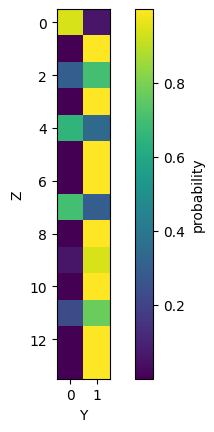

In [26]:
im = plt.imshow(P_Y_Z.T.to('cpu'))
plt.ylabel('Z')
plt.xlabel('Y')
plt.colorbar(im, label='probability')
plt.show()

## Fitting final classifier

In [27]:
val_losses = []
for weight_decay in tqdm(weight_decays_ws, disable=not verbose):
    model = LogReg(X_train.shape[1], set_Y.shape[0]).double().to(device)
    model = TrainModelCI(model, X_train, Z_train, set_Z, P_Y_Z, weight_decay=weight_decay, tol=tol, max_epochs=max_epochs, device=device)
    val_losses.append(CIRisk(GetLogLossTensor(model, X_val), Z_val, set_Z, P_Y_Z, device).item())
model_ws = LogReg(X_train.shape[1], set_Y.shape[0]).double().to(device)
model_ws = TrainModelCI(model_ws, X_train, Z_train, set_Z, P_Y_Z, weight_decay=weight_decays_ws[np.argmin(val_losses)], tol=tol, max_epochs=max_epochs, device=device)

## Evaluation (with Fréchet bounds)

In [46]:
threshs = np.linspace(0.05,.95,20)

In [47]:
eval_bound = {}

for thresh in tqdm(threshs):
    
    y_hat = (model_ws(X_val)[:,1]>thresh).long()
    y_hat_full = (model_ws(torch.vstack((X_test,X_val)))[:,1]>thresh).long()

    eval_bound[thresh] = EvalPWS(y_hat, 'prf', set_Y, set_Z, Z_val, P_Y_Z, device, y_hat_full, Z)

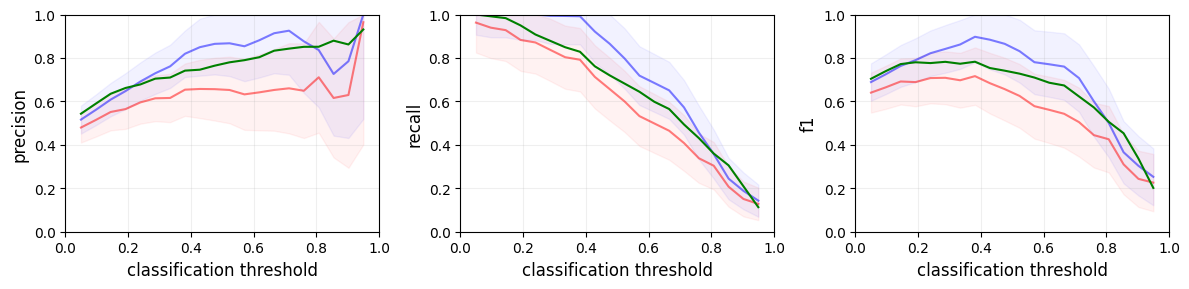

In [48]:
plt.figure(figsize=(12, 3))
colors = {'lower':'red', 'upper':'blue'}

for i,metric in enumerate(['precision','recall','f1']):
    plt.subplot(1, 3, i+1)
    for bound in ['lower','upper']:
        plot_data = np.array([[eval_bound[thresh][bound][metric]['center']]+eval_bound[thresh][bound][metric]['ci'] for thresh in threshs])
    
        plt.plot(threshs, plot_data[:,0], color=colors[bound], alpha=.5)
        plt.fill_between(threshs, plot_data[:,1], plot_data[:,2], color=colors[bound], alpha=.05)
        
    #plot test values
    test_values = []
    for thresh in threshs:
        y_hat = (model_ws(X_test)>thresh)[:,1].to('cpu').numpy().astype('int').tolist()
        y = Y_test
        
        if metric=='precision':
            test_values.append(precision_score(y, y_hat, average='binary')) 
        elif metric=='recall':
            test_values.append(recall_score(y, y_hat, average='binary'))
        else:
            test_values.append(f1_score(y, y_hat, average='binary'))
            
    plt.plot(threshs, test_values, color='green')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.ylabel(metric, size=12)
    plt.xlabel('classification threshold', size=12)
    plt.grid(alpha=.2)
plt.tight_layout()
plt.show()